CMPE249 HW1

Image classification of traffic signs using GTSRB dataset.

Dataset: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code

I have not used the entire 50k+ images from the original dataset. I have used approximately 10,000k images from train and test folders. In the train set, I am using only first six classes ie, 0 thro 5.
Due to resource and time constraint I could not use the entire 50k+ dataset.

Check if tensorflow version is greater than 2. Print tensorflow and keras version.
check GPU availability.

In [ ]:
#!pip install -q tensorflow-gpu==2.0.0  #
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Tensorflow Version:  2.4.1
Keras Version:  2.4.0


In [ ]:
#TPU detection, do together
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
print("Keras Version: ", tf.keras.__version__)

Keras Version:  2.4.0


Import required python libraries

In [ ]:
import pandas as pd
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import PIL
import PIL.Image

In [ ]:
print(strategy.num_replicas_in_sync)

1


The check below is for TPU and GPU. If using GPU acceleration set the batch size to 64. 

In [ ]:
if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 64 # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
print(BATCH_SIZE)

64


Mount google drive as I have stored the dataset in my google drive in GTRB folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Path to my google drive where i have stored the data

In [ ]:
import pathlib
data_dir = '/content/gdrive/MyDrive/GTRB/train'
data_dir = pathlib.Path(data_dir)

Using 9930 images for my homework.

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

9930


Checking the class and the image in that class. Cross verifying with the training set.

In [ ]:
class20 = list(data_dir.glob('0/*'))
PIL.Image.open(str(class20[0]))

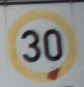

In [ ]:
class30 = list(data_dir.glob('1/*'))
PIL.Image.open(str(class30[10]))

I am using a total of 6 classes.

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['0', '1', '2', '3', '4', '5'], dtype='<U1')

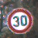

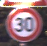

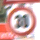

In [ ]:
from IPython.display import Image, display
class30 = list(data_dir.glob('1/*'))

for image_path in class30[:3]:
    display(Image(str(image_path)))

Set the batch size and image size

In [ ]:
batch_size = BATCH_SIZE
img_height = 180
img_width = 180

The steps from here on is to train the model using the images. Define train and validation split. 80% training 20% validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9930 files belonging to 6 classes.
Using 7944 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9930 files belonging to 6 classes.
Using 1986 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5']


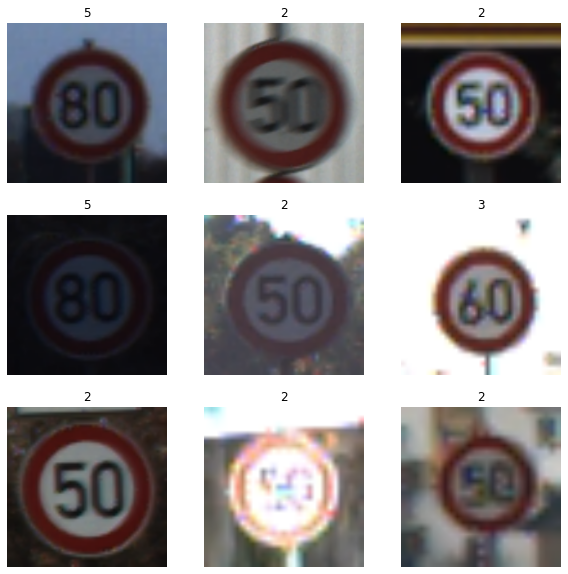

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#manually iterate over the dataset and retrieve batches of images:
#This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


Normalise data. Helps the model in converging fast.

In [ ]:
#Standardize the data, standardize values [0, 255] to be in the [0, 1]
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

#There are two ways to use this layer. You can apply it to the dataset by calling map:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018536655 0.91215575


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train model using images.

In [ ]:
num_classes = 6

model = tf.keras.Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
'''not training here. training using tfrecord
#import time
#start = time.time()
#model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)
end = time.time()

print("Speed test - Total Time taken for GPU acceleration = %.3f seconds "%(end-start))
'''

'not training here. training using tfrecord\n#import time\n#start = time.time()\n#model.fit(\n  train_ds,\n  validation_data=val_ds,\n  epochs=10\n)\nend = time.time()\n\nprint("Speed test - Total Time taken for GPU acceleration = %.3f seconds "%(end-start))\n'

### Create your own tf data pipeline.

## Generate tfrecord. 
Tfrecord is a simple format or storing reocrds in binary format.

Source: https://www.tensorflow.org/tutorials/load_data/tfrecord#:~:text=The%20TFRecord%20format%20is%20a,to%20understand%20a%20message%20type.

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
AUTOTUNE = tf.data.experimental.AUTOTUNE

Create tfrecords for train data and store it in the train_tfrecords dir.

In [ ]:
!mkdir -p /content/gdrive/MyDrive/GTRB/train_tfrecords

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected


In [ ]:
!ls /content/gdrive/MyDrive/GTRB/train_tfrecords

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
train.tfrecords-000  train.tfrecords-002  train.tfrecords-004
train.tfrecords-001  train.tfrecords-003


In [ ]:
# the tfrecord file path
record_path = '/content/gdrive/MyDrive/GTRB/train_tfrecords/'
# number of images stored in each tfrecord file
best_num = 2000
num = 0
record_file_num = 0
keys = [str(i) for i in list(range(0,6))]
values = ['0','1','2', '3', '4','5'] # 6 classes of vehicles
classes = dict(zip(keys,values))

## Convert png images to tfrecord and writing them to tfrecord directory

In [ ]:
# converting jpeg images to tfrecord and writing them to tfrecord directory
cwd = '/content/gdrive/MyDrive/GTRB/train'
record_file_name = ("train.tfrecords-%.3d" % record_file_num)
writer = tf.io.TFRecordWriter(record_path + record_file_name)
print("Creating the 000 tfrecord file")
for name,label in classes.items():
    class_path = os.path.join(cwd, label)
    for img_name in os.listdir(class_path):
        if img_name == '.DS_Store':
            continue
        num += 1
        if num > best_num:
            num = 1
            record_file_num += 1
            record_file_name = ("train.tfrecords-%.3d" % record_file_num)
            writer = tf.io.TFRecordWriter(record_path + record_file_name)
            print("Creating the %.3d tfrecord file" % record_file_num)
       
        img_path = os.path.join(class_path, img_name)
        img_raw = open(img_path, 'rb').read()
        example = tf.train.Example(features=tf.train.Features(feature={
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        "target": tf.train.Feature(int64_list=tf.train.Int64List(value=[int(name)]))}))
        writer.write(example.SerializeToString())
writer.close()

Creating the 000 tfrecord file
Creating the 001 tfrecord file
Creating the 002 tfrecord file
Creating the 003 tfrecord file
Creating the 004 tfrecord file


### Reading TFrecord 

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [ ]:
def readingtfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_img(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int64)
        return image, label
    return image

In [ ]:
from functools import partial

def loadingdataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(readingtfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = loadingdataset(filenames, labeled=labeled)
    return dataset

def configure_for_performance(dataset):
    dataset= dataset.cache()
    dataset = dataset.shuffle(buffer_size=image_count)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

## Prepare the dataset for model training. Use the tfrecords as data for the dataset. 80% training 20%validation.

In [ ]:
tfrcdfiles = tf.io.gfile.glob(record_path + "train.tfrecords*")
dataset = get_dataset(tfrcdfiles) # get the whole dataset

In [ ]:
tfrcdfiles

['/content/gdrive/MyDrive/GTRB/train_tfrecords/train.tfrecords-000',
 '/content/gdrive/MyDrive/GTRB/train_tfrecords/train.tfrecords-001',
 '/content/gdrive/MyDrive/GTRB/train_tfrecords/train.tfrecords-002',
 '/content/gdrive/MyDrive/GTRB/train_tfrecords/train.tfrecords-003',
 '/content/gdrive/MyDrive/GTRB/train_tfrecords/train.tfrecords-004']

In [ ]:
# Splitting dataset into train and validation set
val_size = int(image_count * 0.2)   # 20% for validation
train_size = int(image_count*0.8)   # 80% data for training

dataset = dataset.shuffle(buffer_size = image_count)

train_dataset = dataset.take(train_size)
valid_dataset = dataset.skip(train_size)

train_dataset = configure_for_performance(train_dataset)
valid_dataset = configure_for_performance(valid_dataset)

In [ ]:
print (val_size)

1986


In [ ]:
print (train_size)

7944


In [ ]:
for data in train_dataset:
  print (data)

Streaming output truncated to the last 5000 lines.

        [[ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         ...,
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ]],

        [[ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         ...,
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ]],

        [[ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         [ 64.      ,  63.      ,  46.      ],
         ...,
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ],
         [ 50.      ,  52.      ,  48.      ]]]], dtype=float32)>, <tf.Tensor: shape=(64,), dtype=int64

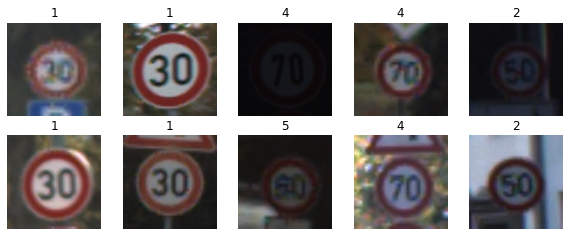

In [ ]:
import random
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(10):
        ax = plt.subplot(5, 5, n + 1)
        rand = random.randint(1,50)
        plt.imshow(image_batch[rand] / 255.0)
        plt.title(classes.get(str(label_batch[rand])))
        plt.axis("off")
image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch,label_batch.numpy())

### Train the model

In [ ]:
from tensorflow.keras import layers,Input
num_classes = 6

model = tf.keras.Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
import time
start = time.time()
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=10)
end = time.time()
print("Speed test - GPU acceleration = %.3f seconds "%(end-start))


Epoch 1/10
125/125 [==============================] - 10s 78ms/step - loss: 17.2471 - accuracy: 0.3983 - val_loss: 0.5474 - val_accuracy: 0.8172
Epoch 2/10
125/125 [==============================] - 6s 47ms/step - loss: 0.4419 - accuracy: 0.8597 - val_loss: 0.3607 - val_accuracy: 0.8933
Epoch 3/10
125/125 [==============================] - 6s 47ms/step - loss: 0.3249 - accuracy: 0.9027 - val_loss: 0.3370 - val_accuracy: 0.8998
Epoch 4/10
125/125 [==============================] - 6s 47ms/step - loss: 0.2384 - accuracy: 0.9291 - val_loss: 0.1887 - val_accuracy: 0.9431
Epoch 5/10
125/125 [==============================] - 6s 47ms/step - loss: 0.1515 - accuracy: 0.9587 - val_loss: 0.1736 - val_accuracy: 0.9537
Epoch 6/10
125/125 [==============================] - 6s 47ms/step - loss: 0.1391 - accuracy: 0.9600 - val_loss: 0.1694 - val_accuracy: 0.9572
Epoch 7/10
125/125 [==============================] - 6s 47ms/step - loss: 0.0931 - accuracy: 0.9733 - val_loss: 0.0966 - val_accuracy: 0.97

### Plot the training-validation accuracy and loss curves

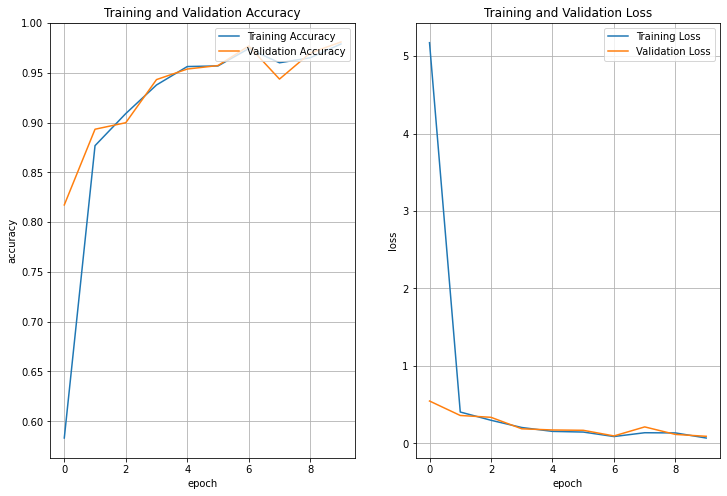

In [ ]:
def plot_history(history, metric, val_metric):
  acc = history.history[metric]
  val_acc = history.history[val_metric]

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(len(acc))

  fig=plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper right')
  plt.ylim([min(plt.ylim()),1])
  plt.grid(True)
  plt.title('Training and Validation Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.title('Training and Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()
  #fig.savefig('traininghistory.pdf')

plot_history(history, 'accuracy', 'val_accuracy')


### **Inference. 
Save model before evaluation.

In [ ]:
!mkdir -p '/content/gdrive/MyDrive/GTRB/saved_model'

In [ ]:
!mkdir -p /content/gdrive/MyDrive/GTRB/saved_model/model

In [ ]:
os.chdir('/content/gdrive/MyDrive/GTRB')

In [ ]:
!pwd

/content/gdrive/MyDrive/GTRB


In [ ]:
!ls '/content/gdrive/MyDrive/GTRB'

converted_model.tflite			  model.zip	    train
german-traffic-signs-preprocessing.ipynb  saved_model	    Train.csv
Meta.csv				  speedlimit20.jpg  train_tfrecords
model_finetune.zip			  test
model_hw.h5				  Test.csv


In [ ]:
model.save('/content/gdrive/MyDrive/GTRB/saved_model/model/', save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GTRB/saved_model/model/assets


In [ ]:
!cd '/content/gdrive/MyDrive/GTRB/saved_model/'

In [ ]:

!ls 

converted_model.tflite			  model.zip	    train
german-traffic-signs-preprocessing.ipynb  saved_model	    Train.csv
Meta.csv				  speedlimit20.jpg  train_tfrecords
model_finetune.zip			  test
model_hw.h5				  Test.csv


In [ ]:
!zip model.zip -r /content/gdrive/MyDrive/GTRB/saved_model/model/

updating: content/gdrive/MyDrive/GTRB/saved_model/model/ (stored 0%)
updating: content/gdrive/MyDrive/GTRB/saved_model/model/variables/ (stored 0%)
updating: content/gdrive/MyDrive/GTRB/saved_model/model/variables/variables.index (deflated 67%)
updating: content/gdrive/MyDrive/GTRB/saved_model/model/variables/variables.data-00000-of-00001 (deflated 28%)
updating: content/gdrive/MyDrive/GTRB/saved_model/model/assets/ (stored 0%)
updating: content/gdrive/MyDrive/GTRB/saved_model/model/saved_model.pb (deflated 88%)


In [ ]:
!ls /content

gdrive	sample_data


In [ ]:
!cp ./model.zip /content/gdrive/MyDrive/'Colab Notebooks'

In [ ]:
!ls /content/gdrive/MyDrive/GTRB/saved_model

model  model_finetune  model_finetune.zip  model.zip


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('model_hw.h5')

In [ ]:
# Recreate the exact same model
newsaved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/GTRB/saved_model/model/')

In [ ]:
newsaved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)            

### TF lite inference

In [ ]:
start_tfliteinference = time.time()

In [ ]:
import tensorflow as tf
saved_model_dir = '/content/gdrive/MyDrive/GTRB/saved_model/model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

6637808

In [ ]:
!ls

converted_model.tflite			  model.zip	    train
german-traffic-signs-preprocessing.ipynb  saved_model	    Train.csv
Meta.csv				  speedlimit20.jpg  train_tfrecords
model_finetune.zip			  test
model_hw.h5				  Test.csv


In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_shape

array([  1, 180, 180,   3], dtype=int32)

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_conv2d_3_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 180, 180,   3], dtype=int32),
  'shape_signature': array([ -1, 180, 180,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 20,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 6], dtype=int32),
  'shape_signature': array([-1,  6], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
end_tfliteinference = time.time()
print("Speed test - GPU acceleration Inference = %.3f seconds "%(end_tfliteinference-start_tfliteinference))


Speed test - GPU acceleration Inference = 14.442 seconds 


#Evaluate the model. Pick an image from test folder and see if the model predicts it correctly. 

In [ ]:
import numpy as np
from numpy import asarray
from PIL import Image
#Taking one image from class 3
path = '/content/gdrive/MyDrive/GTRB/test/00024.png'
class_type = Image.open(path).resize((180, 180))
class_type = np.array(class_type)
input=class_type[np.newaxis, ...]
class_names=[0,1,2,3,4,5]

In [ ]:
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data.shape

(1, 180, 180, 3)

[[ 2.157766 16.789854 12.533718 15.834909 -8.38356  13.891655]]
This image most likely belongs to 1 with a 16.79 percent confidence.


(-0.5, 179.5, 179.5, -0.5)

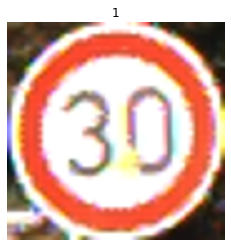

In [ ]:
input_data = np.array(input, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

result = interpreter.get_tensor(output_details[0]['index'])
print(result)
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
       .format(classes.get(str(class_names[np.argmax(result)])), np.max(result))
   )

plt.imshow(class_type)
plt.title(classes.get(str(class_names[np.argmax(result)])))
plt.axis("off")



### In the above case, the prediction was correct because speed limit 30 sign belongs to class 1

### Evaluate the model on a a batch on images from the test set

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
label_batch

array([3, 5, 2, 3, 3, 4, 4, 3, 3, 1, 2, 5, 4, 2, 4, 4, 1, 4, 4, 4, 2, 2,
       4, 5, 4, 5, 4, 2, 5, 4, 2, 4, 2, 2, 1, 3, 2, 5, 2, 5, 3, 5, 1, 2,
       4, 5, 4, 1, 5, 1, 2, 1, 1, 1, 2, 4, 5, 5, 1, 2, 3, 2, 2, 4],
      dtype=int32)

In [ ]:
predictions = newsaved_model.predict(image_batch) #.flatten()
predictions

array([[-1.73440285e+01, -1.46085939e+01, -1.02570848e+01,
         2.20430870e+01, -1.57842741e+01, -1.53395927e+00],
       [-4.52709103e+00, -5.04512215e+00, -4.40653831e-01,
        -1.28585339e+00, -1.08538370e+01,  1.02605886e+01],
       [-2.04616013e+01, -2.22450662e+00,  1.58520727e+01,
         1.56209326e+00,  2.03744459e+00,  5.39682293e+00],
       [-5.38111019e+00,  7.81027153e-02,  9.91980672e-01,
         1.27324820e+01, -1.29666872e+01,  4.70618010e+00],
       [-6.30631065e+00,  6.03505707e+00, -1.32505685e-01,
         1.63635826e+01, -1.98613510e+01,  6.58174181e+00],
       [-1.18891954e+01,  8.42927337e-01, -3.88560033e+00,
        -2.00507450e+01,  1.91465244e+01, -5.70738935e+00],
       [-4.24464941e+00,  6.48717284e-01, -3.33838749e+00,
        -2.28543115e+00,  1.04319944e+01,  2.51358795e+00],
       [-1.58217955e+01, -5.28509855e+00, -2.20787978e+00,
         2.79924850e+01, -7.58219004e+00,  1.23650694e+01],
       [-1.58473806e+01, -2.01812506e+00,  7.386

In [ ]:
predictions = model.predict(image_batch) #.flatten()
predictions

array([[-2.55555763e+01, -3.80927134e+00,  4.35072613e+00,
         2.30770607e+01,  2.50959682e+00,  1.11890163e+01],
       [-1.15540524e+01, -6.84259462e+00,  2.10806561e+00,
        -7.75596428e+00, -5.20763063e+00,  1.35080538e+01],
       [-7.52123117e+00,  1.07531576e+01,  1.66880932e+01,
        -3.24249959e+00,  1.02381306e+01,  8.76264000e+00],
       [-9.17662907e+00,  1.34689379e+00,  5.38518238e+00,
         1.31729155e+01, -8.35234928e+00,  7.72494888e+00],
       [-1.60542736e+01, -3.73923159e+00,  5.59548759e+00,
         2.16785069e+01, -1.34067993e+01,  6.75693321e+00],
       [ 8.10674953e+00,  1.68403912e+01, -8.41649652e-01,
        -2.05707550e+01,  2.86925240e+01,  1.44422178e+01],
       [-1.14994073e+00,  3.20562410e+00,  1.44262326e+00,
        -9.19488251e-01,  8.13473511e+00,  1.22876287e+00],
       [-3.24051170e+01,  8.83134460e+00,  8.63261604e+00,
         3.46166229e+01, -1.46183634e+01,  1.42345982e+01],
       [-1.13721457e+01, -5.41672993e+00,  8.259

In [ ]:
predictions.shape

(64, 6)

In [ ]:
predictions[0].shape

(6,)

In [ ]:
#Apply a softmax since our model returns logits
prediction0 = tf.nn.softmax(predictions[0])
prediction0

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([7.5702652e-22, 2.1057732e-12, 7.3663720e-09, 9.9999309e-01,
       1.1685878e-09, 6.8720287e-06], dtype=float32)>

In [ ]:
objid=np.argmax(prediction0, axis=-1)
objid

3

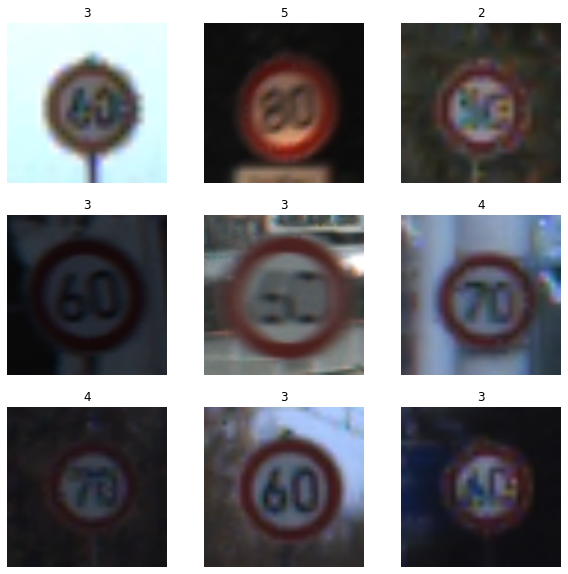

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  prediction_current = tf.nn.softmax(predictions[i])
  objid=np.argmax(prediction_current, axis=-1)
 # groundtruth=labels[label_batch[i]]
  plt.title(objid)
 # plt.title(classes.get(str(class_names[np.argmax(objid)])))
  plt.axis("off")

### **The model has predicted the unseen test class images correctly. 
Class 0 - speed limit 20
class 1 - 30
class 2 - 50
class 3 - 60
class 4 - 70
class 5 - 80**



Inference from web. Pulled an image from google to see if the model predicts the traffic sign correctly

(-0.5, 179.5, 179.5, -0.5)

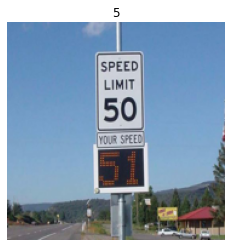

In [ ]:
import requests
from io import BytesIO
link = 'https://www.trafficsafetywarehouse.com/images/RU2%20350%202014.JPG'
#link = 'https://media.istockphoto.com/photos/speed-limit-traffic-sign-80-on-the-road-in-france-picture-id1006205034?s=612x612'
response = requests.get(link)
image = Image.open(BytesIO(response.content)).resize((180,180))
image = np.array(image)
input=image[np.newaxis, ...]
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data.shape
input_data = np.array(input, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
plt.imshow(image)
plt.title(classes.get(str(class_names[np.argmax(output_data)])))
plt.axis("off")